In [2]:
# set up Dependencies
import pandas as pd
import numpy as np
import requests
import time
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
from citipy import citipy

# import api key from environment variables
weather_api_key = os.environ.get('WEATHER_API_KEY')

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [6]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set(set_size) of random lat and lng combinations
set_size=1500
lats = np.random.uniform(lat_range[0], lat_range[1], size=set_size)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=set_size)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1])
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))

615


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).

In [7]:
# Build url for weather api call. Set units to imperial
base_url = "https://api.openweathermap.org/data/2.5/weather?"
units = "&units=imperial"
API_KEY = "&appid="+str(weather_api_key)

# create lists for data from api responses
city_names = []
city_lats = []
city_lons = []
max_temps = []
humidities = []
cloudies = []
wind_spds = []
countries = []
dates = []

# --------- Record Processing Loop ----------
for city in cities:
    # wait 1 second between each API call so calls/per/minute-limit is not reached
    time.sleep(1)

    # print process log
    print("Processing Record " + str((cities.index(city) + 1)) + " of " + str(len(cities)) + " | " + city.city_name)
    
    # build URL for each city
    URL = base_url + "q=" + city.city_name + "," + city.country_code + units + API_KEY
    
    # HTTP request
    response = requests.get(URL)

    # checking the status code of the request
    if response.status_code == 200:
        city_names.append(city.city_name)
        countries.append(city.country_code)

        # getting data in the json format
        data = response.json()
        # getting the coord, main, clouds, wind dict blocks
        main = data['main']
        coord = data['coord']
        clouds = data['clouds']
        wind = data['wind']
        # getting city coordinates
        city_lats.append(coord['lat'])
        city_lons.append(coord['lon'])
        # getting max temperature
        max_temps.append(main['temp_max'])
        # getting the humidity
        humidities.append(main['humidity'])     
        # getting cloudiness %
        cloudies.append(clouds['all'])
        # getting wind speed
        wind_spds.append(wind['speed'])
        # getting time of data calculation, unix, UTC
        dates.append(data['dt'])
    else:
        # showing the error message
        print("Error in the HTTP request")

# --------- end ---------

 of 615 | fallon
Processing Record 149 of 615 | ancud
Processing Record 150 of 615 | aksarka
Processing Record 151 of 615 | campos
Processing Record 152 of 615 | riyadh
Processing Record 153 of 615 | aracuai
Processing Record 154 of 615 | zaozerne
Processing Record 155 of 615 | new norfolk
Processing Record 156 of 615 | lorengau
Processing Record 157 of 615 | buala
Processing Record 158 of 615 | prescott
Processing Record 159 of 615 | zhangjiakou
Processing Record 160 of 615 | butaritari
Processing Record 161 of 615 | vaitape
Processing Record 162 of 615 | izumo
Processing Record 163 of 615 | port-gentil
Processing Record 164 of 615 | viedma
Processing Record 165 of 615 | hami
Processing Record 166 of 615 | mar del plata
Processing Record 167 of 615 | krasnaya gorbatka
Processing Record 168 of 615 | sotuta
Processing Record 169 of 615 | auray
Processing Record 170 of 615 | olafsvik
Processing Record 171 of 615 | igarka
Processing Record 172 of 615 | bay roberts
Processing Record 173 of

In [8]:
# create a dictionary from lists that were filled from api calls
weather_dict = {"City" : city_names, "Lat" : city_lats, "Lng" : city_lons, 
"Max Temps" : max_temps, "Humidity" : humidities, "Cloudiness" : cloudies,
"Wind Speed" : wind_spds, "Country" : countries, "Date" : dates}

# convert dictionary to dataframe
weather_df = pd.DataFrame(weather_dict)

print(weather_df.head())

          City      Lat       Lng  Max Temps  Humidity  Cloudiness  \
0       bethel  41.3712  -73.4140      57.20        24           1   
1    busselton -33.6500  115.3333      55.99        99           5   
2  muyezerskiy  63.9333   31.6500      26.91        78          38   
3      rikitea -23.1203 -134.9692      75.67        80          93   
4     thompson  55.7435  -97.8558      23.00        86          90   

   Wind Speed Country        Date  
0        4.38      us  1619915022  
1        3.49      au  1619914992  
2        9.19      ru  1619915088  
3        8.52      pf  1619915020  
4        9.22      ca  1619915090  


In [9]:
# if there are any cities with humidity > 100, drop them. Otherwise data is clean.
if(weather_df.index[weather_df["Humidity"] > 100].empty):
    clean_weather_df = weather_df  
else:
    clean_weather_df = weather_df.drop(
        weather_df.index[weather_df["Humidity"] > 100])

# export to csv
clean_weather_df.to_csv('part1.csv', index=False)

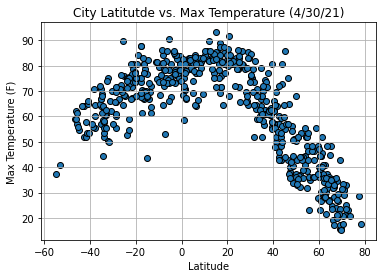

<Figure size 432x288 with 0 Axes>

In [10]:
# make a function to expedite plotting process
def scatter_plot(x, y, xlabel, ylabel, title):
    plt.scatter(x, y, edgecolors='k')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

# scatter plot of City Latitutde vs. Max Temperature
scatter_plot(clean_weather_df['Lat'],clean_weather_df['Max Temps'],
    "Latitude","Max Temperature (F)",
    "City Latitutde vs. Max Temperature (4/30/21)")

#save as a png image
plt.savefig("MaxTemperatureVsWorldLat.png")

### The plot shows a strong correlation between high max temperature and proximity to 0-Latitude or Equator.


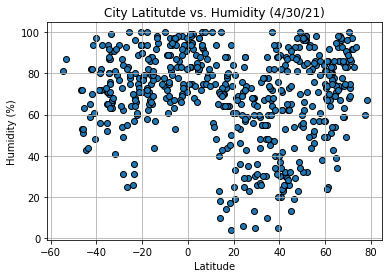

<Figure size 432x288 with 0 Axes>

In [11]:
# scatter plot of City Latitutde vs. Humidity
scatter_plot(clean_weather_df['Lat'],clean_weather_df['Humidity'],
    "Latitude","Humidity (%)",
    "City Latitutde vs. Humidity (4/30/21)")

#save as a png image
plt.savefig("HumidityVsWorldLat.png")

### The plot shows the lowest humidity levels concentrated just above the Equator, but otherwise very little correlation between Latitude and humidity.


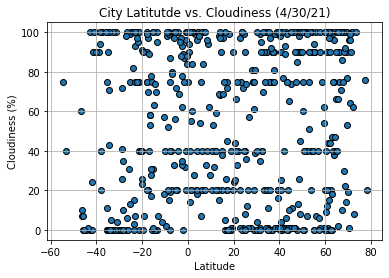

<Figure size 432x288 with 0 Axes>

In [12]:
# scatter plot of City Latitutde vs. Cloudiness
scatter_plot(clean_weather_df['Lat'],clean_weather_df['Cloudiness'],
    "Latitude","Cloudiness (%)",
    "City Latitutde vs. Cloudiness (4/30/21)")

#save as a png image
plt.savefig("CloudinessVsWorldLat.png")

### The plot shows virtually zero correlation bewteen city Latitude and cloudiness.


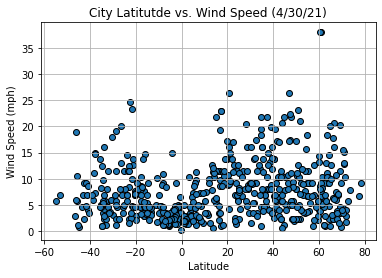

<Figure size 432x288 with 0 Axes>

In [13]:
# scatter plot of City Latitutde vs. Wind Speed
scatter_plot(clean_weather_df['Lat'],clean_weather_df['Wind Speed'],
    "Latitude","Wind Speed (mph)",
    "City Latitutde vs. Wind Speed (4/30/21)")

#save as a png image
plt.savefig("WindSpeedVsWorldLat.png")

### The plot shows a lack in high wind speeds at the lowest Latitudes, but ptherwise very little correlation between Latitude and wind speed.

In [14]:
# DataFrame of clean_weather_df where Northern Hemisphere==True 
north_weather_df = clean_weather_df.drop(clean_weather_df.index[clean_weather_df['Lat'] < 0])
print(north_weather_df.head())

# DataFrame of clean_weather_df where Southern Hemisphere==True 
south_weather_df = clean_weather_df.drop(clean_weather_df.index[clean_weather_df['Lat'] > 0])
print(south_weather_df.head())


          City      Lat      Lng  Max Temps  Humidity  Cloudiness  Wind Speed  \
0       bethel  41.3712 -73.4140      57.20        24           1        4.38   
2  muyezerskiy  63.9333  31.6500      26.91        78          38        9.19   
4     thompson  55.7435 -97.8558      23.00        86          90        9.22   
5    ostersund  63.1792  14.6357      30.20        80          47        5.75   
6    ilulissat  69.2167 -51.1000      42.80        49          14       11.50   

  Country        Date  
0      us  1619915022  
2      ru  1619915088  
4      ca  1619915090  
5      se  1619915092  
6      gl  1619915093  
            City      Lat       Lng  Max Temps  Humidity  Cloudiness  \
1      busselton -33.6500  115.3333      55.99        99           5   
3        rikitea -23.1203 -134.9692      75.67        80          93   
8        ushuaia -54.8000  -68.3000      37.40        81          75   
9   punta arenas -53.1500  -70.9167      41.00        87          40   
11      h

In [15]:
def scatter_linreg(x, y, xlabel, ylabel, title):
    #regression part
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    # print r-value
    print("The r-value is : " + str(r_value**2))
    line = slope*x+intercept
    plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
    plt.legend()
    scatter_plot(x, y, xlabel, ylabel, title)

The r-value is : 0.7842352906455557


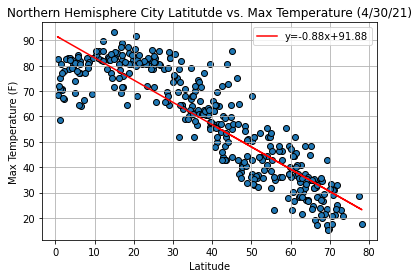

The r-value is : 0.48290747676568974


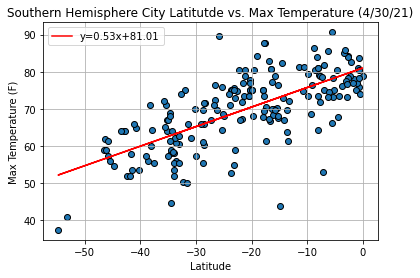

<Figure size 432x288 with 0 Axes>

In [16]:
#                      Set 1
# scatter plot with linear regression line of
# Northern Hemisphere City Latitutde vs. Max Temperature
scatter_linreg(north_weather_df['Lat'],north_weather_df['Max Temps'],
    "Latitude","Max Temperature (F)",
    "Northern Hemisphere City Latitutde vs. Max Temperature (4/30/21)")
#save as a png image
plt.savefig("MaxTemperatureVsNorthLat.png")

# scatter plot with linear regression line of
# Southern Hemisphere City Latitutde vs. Max Temperature
scatter_linreg(south_weather_df['Lat'],south_weather_df['Max Temps'],
    "Latitude","Max Temperature (F)",
    "Southern Hemisphere City Latitutde vs. Max Temperature (4/30/21)")
#save as a png image
plt.savefig("MaxTemperatureVsSouthLat.png")

### Note the R-values are relatively high. We can clearly see, in both Hemispheres, an increase in Max Temperatue as the cities approach the Equator.


The r-value is : 0.0019563507795216347


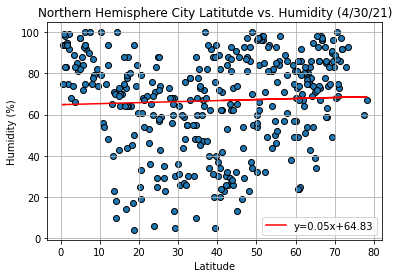

The r-value is : 0.09144154526400972


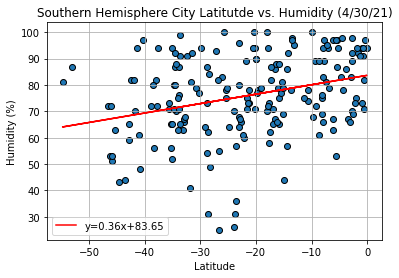

<Figure size 432x288 with 0 Axes>

In [17]:
#                       Set 2
# scatter plot with linear regression line of
# Northern Hemisphere City Latitutde vs. Humidity
scatter_linreg(north_weather_df['Lat'],north_weather_df['Humidity'],
    "Latitude","Humidity (%)",
    "Northern Hemisphere City Latitutde vs. Humidity (4/30/21)")
#save as a png image
plt.savefig("HumidityVsNorthLat.png")

# scatter plot with linear regression line of
# Southern Hemisphere City Latitutde vs. Humidity
scatter_linreg(south_weather_df['Lat'],south_weather_df['Humidity'],
    "Latitude","Humidity (%)",
    "Southern Hemisphere City Latitutde vs. Humidity (4/30/21)")
#save as a png image
plt.savefig("HumidityVsSouthLat.png")

### Note the R-values are both very close to zero. While slightly higher in the Northern Hemisphere, we still see very little correlation between Latitude and humidity by hemisphere - and almost none in the Southern.


The r-value is : 0.010132796044258995


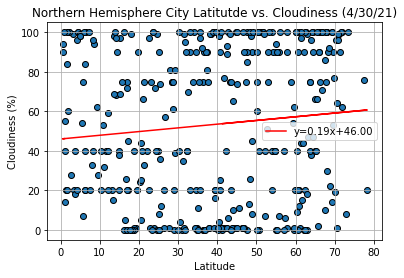

The r-value is : 0.0662715268294757


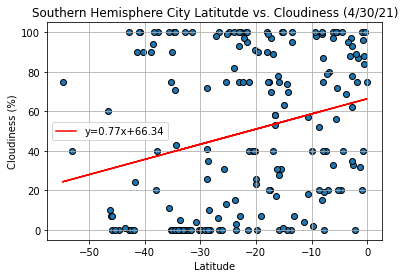

<Figure size 432x288 with 0 Axes>

In [18]:
#                       Set 3
# scatter plot with linear regression line of
# Northern Hemisphere City Latitutde vs. Cloudiness
scatter_linreg(north_weather_df['Lat'],north_weather_df['Cloudiness'],
    "Latitude","Cloudiness (%)",
    "Northern Hemisphere City Latitutde vs. Cloudiness (4/30/21)")
#save as a png image
plt.savefig("CLoudinessVsNorthLat.png")

# scatter plot with linear regression line of
# Southern Hemisphere City Latitutde vs. Cloudiness
scatter_linreg(south_weather_df['Lat'],south_weather_df['Cloudiness'],
    "Latitude","Cloudiness (%)",
    "Southern Hemisphere City Latitutde vs. Cloudiness (4/30/21)")
#save as a png image
plt.savefig("CloudinessVsSouthLat.png")

### Note the R-values are both very close to zero. While slightly higher in the Northern Hemisphere, we still see very little correlation between Latitude and cloudiness by hemisphere - and almost none in the Southern.


The r-value is : 0.009104540845862593


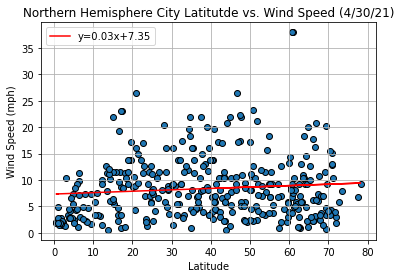

The r-value is : 0.06012845825367412


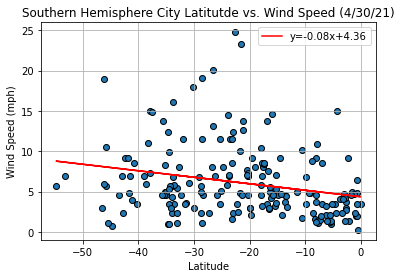

<Figure size 432x288 with 0 Axes>

In [19]:
#                       Set 4
# scatter plot with linear regression line of
# Northern Hemisphere City Latitutde vs. Wind Speed
scatter_linreg(north_weather_df['Lat'],north_weather_df['Wind Speed'],
    "Latitude","Wind Speed (mph)",
    "Northern Hemisphere City Latitutde vs. Wind Speed (4/30/21)")
#save as a png image
plt.savefig("WindSpeedVsNorthLat.png")

# scatter plot with linear regression line of
# Southern Hemisphere City Latitutde vs. Wind Speed
scatter_linreg(south_weather_df['Lat'],south_weather_df['Wind Speed'],
    "Latitude","Wind Speed (mph)",
    "Southern Hemisphere City Latitutde vs. Wind Speed (4/30/21)")
#save as a png image
plt.savefig("WindSpeedVsSouthLat.png")

### Note the R-values are extremely close to zero. Virtually no correlation between wind speed and latitude in the Northern Hemisphere. The little correlation in the Southern does depict a lack of high wind speeds at the lowest latitudes. 
